Sattelite Image analysis using python


Aria Burk
u1102905@utah.edu
1102905

Joseph Cochran 
u1193064@utah.edu
1193064

John Simonyan
u0969548@utah.edu
0969548

Background and Motivation:
As a group, each of us took an interest in NASA’s public APIs and the possibilities of implementing data science within the context of geoscience. Satellite imagery collected in near real-time all across the globe can be quite valuable for those who want to better understand weather patterns, geographical changes over time, disaster prediction/prevention, and many other large-scale surveys.

Sattelite image anaylsis can have a plethora of pracitcal applicatons. Because sattelites can take pictures all over the surface of the planet they can capture formations and patterns in ways we can't see on the ground. In 2019 a group of researchers trained an ai to find geoglyphs, discovering new sets of Nazca lines (Becky Little,https://www.history.com/news/nazca-lines-peru-ai). This just shows one example of the potential of large scale sattelite image analysis. 


Project Objectives:
    Explore the meta data collected (especially from the EPIC API) to find meaningful correlations between different labels and geographical coordinates.
  Listed below are some flexible objectives that we can expand on or dismiss during our project’s exploratory phase.
Explore the metadata collected and associated with each image to find meaningful correlations between different labels and geographical coordinates or other identifiers.
    Analyze select images and develop an algorithm that determines whether the images are similar enough to contain the same subject or location.
    Inversely, find different images of the same subject or location, test the previous algorithm’s accuracy, and compare it with different methodologies.
Test datasets against other tracked events to find correlations and potential patterns
    Train models on datasets to make predictions on a set of qualifiers based on the datasets


Data:
    By querying this nasa api at https://api.nasa.gov/planetary/earth/imagery, we receive a base64 encoded png image that was taken by nasa. 
    Images have longitude, latitude, dimesions of the image, and the date the image was taken as datapoint attributes.
    Geo.json dataset containing latitude and longitude along with other attributes, city, country. Using these patameters we can more clearly classify the queried data.
    Cross referencing our image queries with locational queries to find relevent metadata to apply to our images.
    Metadata exploratory analysis can ecpand dataset very quickly.

TODO:
1. Specify what dataset we want(The geojson I found is of u.s. cities ) I.e which cities/dates to pull from
2. iterate through geoJson making api calls with every iteration
3. Time out iteration to not overload api.
4. save response data to files as png with appropriate classifiers to categorize images appropriately
5. write out method to parse images to histogram or heat map
6. plot out color ranges and heatmap ranges for all the images
7. analyize data ranges to make some predictions or inferences
8. Generate appropriate dataframes with images and img metadata for an easy visualization
    

In [1]:
#load csv of city coordinates
import pandas as pd
from IPython.core.display import HTML

us_cities = pd.read_csv("uscities.csv")
cities_head = us_cities.head()
cities_head
# cities_head.lat
# cities_head.lng
# for i in cities_head:
#     print(i)    
utah_coord = us_cities.loc[us_cities['state_name'] == "Utah"]


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
43,Salt Lake City,Salt Lake City,UT,Utah,49035,Salt Lake,40.7777,-111.9306,1098526,699,polygon,False,True,America/Denver,1,84116 84115 84113 84112 84111 84144 84128 8418...,1840021383
78,Ogden,Ogden,UT,Utah,49057,Weber,41.2278,-111.9682,578523,1230,polygon,False,True,America/Denver,2,84404 84401 84403 84244 84407 84408 84409 84415,1840020135
85,Provo,Provo,UT,Utah,49049,Utah,40.2457,-111.6457,500617,1080,polygon,False,True,America/Denver,2,84604 84606 84601 84602 84603 84605,1840020174
333,West Valley City,West Valley City,UT,Utah,49035,Salt Lake,40.6889,-112.0115,135248,1472,polygon,False,True,America/Denver,2,84119 84120 84128 84118 84125 84126 84127 8412...,1840021389
366,St. George,St. George,UT,Utah,49053,Washington,37.0770,-113.5770,120899,449,polygon,False,True,America/Denver,2,84770 84790 84791,1840021559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27484,Echo,Echo,UT,Utah,49043,Summit,40.9803,-111.4393,49,23,polygon,False,False,America/Denver,3,84024,1840024183
27774,Clear Creek,Clear Creek,UT,Utah,49007,Carbon,39.6429,-111.1547,37,69,polygon,False,False,America/Denver,3,84526,1840024370
27813,Sutherland,Sutherland,UT,Utah,49027,Millard,39.3896,-112.6400,34,6,polygon,False,False,America/Denver,3,84624,1840024465
27951,Oasis,Oasis,UT,Utah,49027,Millard,39.2923,-112.6290,28,28,polygon,False,False,America/Denver,3,84624,1840024464


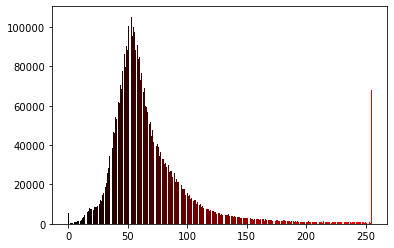

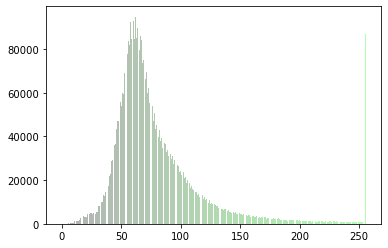

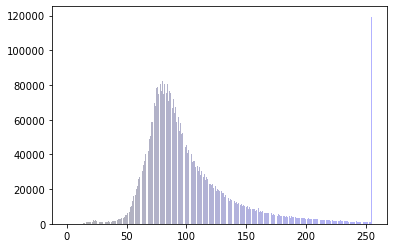

In [40]:
import requests
import base64
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np 
import os

from PIL import Image
from io import BytesIO

#example query
# url = "https://api.nasa.gov/planetary/earth/imagery?lon=-111.9306&lat=40.7777&dim=.2&date=2020-04-26&api_key=II3XUxmGYfFKmyapNeXjrH3Os3ILNhQScjW6bbMT"
# response = requests.get(url)

#image returned 
# i = Image.open(BytesIO(response.content))
# i

#images is saved to file with city name and date taken as format
# i.save('slc_2020_04_26.png')

image_test = Image.open('slc_2020_04_26.png')

#img to histogram
img_hst = image_test.histogram()

#seperate rgb values from histogram to plot seperately
def getRed(R): 
    return '#%02x%02x%02x'%(R,0,0)
def getGreen(G): 
    return '#%02x%02x%02x'%(0,G,0)
def getBlue(B):
    return '#%02x%02x%02x'%(0,0,B)

#iterate through img histogram to find rgb values
Red=img_hst[0:256] # indicates Red
Green=img_hst[256:512] # indicated Green
Blue=img_hst[512:768] # indicates Blue

for i in range(0, 256):
    plt.bar(i, Red[i], color = getRed(i),alpha=1)
    plt.figure(1) # plot red
for i in range(0, 256):
    plt.bar(i, Green[i], color = getGreen(i),alpha=0.3)
    plt.figure(2) # plot green
for i in range(0, 256):
    plt.bar(i, Blue[i], color = getBlue(i),alpha=0.3)
    plt.figure(3) #plot blue
plt.show()


Ethical considerations:
    Regarding our datasets, there is an uncertain degree of bias that affects the process of taking satellite imagery. Perhaps some regions are more “photogenic” or are more likely to have specific documented events such as natural disasters or the like. Considering this, we should be mindful that our interpretations may be influenced by imaging bias or analytical bias. If a similar analysis to this project was used for developing maps or for disaster prevention efforts, there could be a wide range of consequences.


Data Processing:
    Utilizing geo.json coordinates to load parameters for api queries. By using different location sets we can find significant locations to test. By normalizing the query data we can train a test model to recognize certain types of images based on different parameters. Parameters can be based on expected attributes of trained datasets.
    As we collect our data, we will need to process images, sort visual findings, and store our conclusions. We plan to use built-in python packages to visualize our results (i.e., see trends in data, and portray model fitments). These packages include, but are not limited to, NumPy, SciPy, SciKit Learn, Matplotlib, and NASA’s Bingo. Data Processing will be the crux of this project and allow us to come to many conclusions about weather patterns, climate change, and other geographic changes that we might see. Skills we have learned throughout this semester will aid in these tasks.
    Allocating the appropriate metadata to allow us to make hypothetical predictions about changes occurring due to features outside of the received information. By categorizing locational data appropriately, we can classify regions by qualities outside of just its specific location. The features found in regions with rockier terrain or in areas affected by changes in temperature are all valuable classifiers that we can make predictions and base models on.

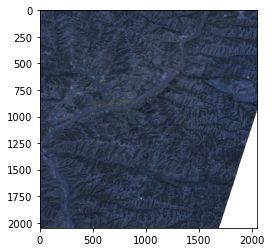

In [50]:
#example query from a previous date
url = "https://api.nasa.gov/planetary/earth/imagery?lon=111.10&lat=39.01&dim=.25&date=2019-03-26&api_key=II3XUxmGYfFKmyapNeXjrH3Os3ILNhQScjW6bbMT"
response = requests.get(url)

#image returned for comparison 
i2 = Image.open(BytesIO(response.content))

#plotted and by using our dimendions we can measure distances and scale accurately
imgplot = plt.imshow(i2)
plt.show()

Exploratory Analysis:
    As outlined in our Project Objectives, metadata associated with each image may be an essential way to navigate, categorize, and classify the items within our dataset. Doing preliminary analysis with the metadata might reveal relationships we want to explore further, deter us from other approaches, and act as a foundation for any further studies involved with image processing. 
    By taking image data from the same location over a given period of time, we will be able to identify changes in location regardless of any temporal factors. Pixel analysis to a heat map can show change in color, or with the right masking tools change in geographical features and or cloud coverage. 


Analysis Methodology:
    Cross references our datasets against normalized test data, to ensure results our results are within the expected range. Sampling random queries can allow us to double check and validate before we make any assertions based on false data processing. We want to ensure as much accuracy as possible, by allocating the appropriate stopgaps in our data analysis we can maintain some control over any potential analysis inaccuracies.



Project Schedule:
March 26th - Project Proposal Due
April 6th - Target for Cleaned/Explored Dataset
April 11th - Project Milestone Due
April 22nd - Target for Completed Screen-Cast Presentation
April 25th - Final Project Submission

Sources:
Geojson with cites lat and lon and additional attributes. https://simplemaps.com/data/us-cities